Most of the Papers either use Linear Noise Scheduler or Cosine Schedule.

- Linear 
- Cosine
- Karras etc

So, will try to use, DDPM with Cosine Beta Scheduler (well or even DDIM)

- Also implement the Time Embedding Block, (Implementing Same Time Embedding Block as that of DiT Paper)

          Scalar timestep (t)
                 │
        Sinusoidal Positional Encoding
                 │
             MLP (2-layer)
                 │
     Time Embedding Vector (dim = hidden_size)
                 │
     Time Embedding(batchSize, EMbedding Dimension)

In [17]:
import torch
from diffusers import DDPMScheduler, DDIMScheduler
from PIL import Image
import matplotlib.pyplot as plt
import math
from torchvision import transforms
from IPython.display import display
import io
import torch.nn as nn
from IPython.display import Image as IPyImage, display
from IPython.display import HTML


In [10]:
ddpmCosine = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")
ddimCosine = DDPMScheduler(num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2")

(np.float64(-0.5), np.float64(5183.5), np.float64(3887.5), np.float64(-0.5))

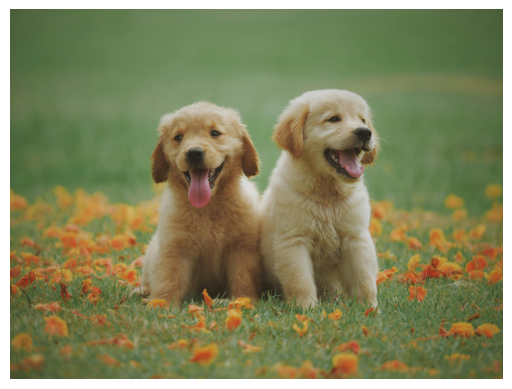

In [11]:
image = Image.open("Images/testImage.jpg")
plt.imshow(image)
plt.axis('off')

In [12]:
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()])

imgTensor = transform(image).unsqueeze(0)
imgTensor.shape

torch.Size([1, 3, 512, 512])

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

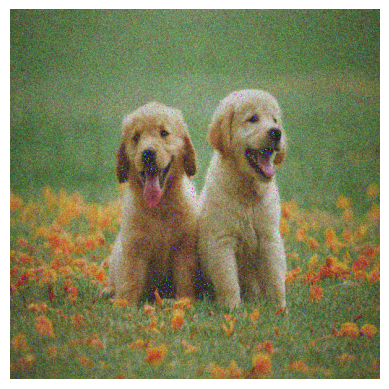

In [13]:
t = 50
noise = torch.randn_like(imgTensor)
alphaT = ddpmCosine.alphas_cumprod[t].view(1, 1, 1, 1)
noisyImg = torch.sqrt(alphaT) * imgTensor + torch.sqrt(1 - alphaT) * noise
nimg = transforms.functional.to_pil_image(noisyImg.squeeze(0))
plt.imshow(nimg)
plt.axis('off')

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

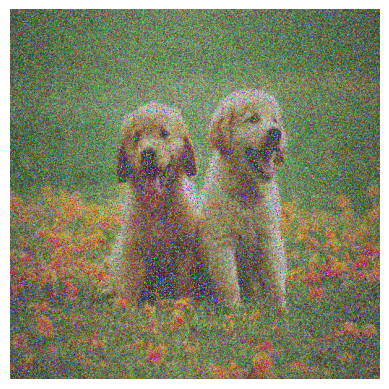

In [14]:
def addNoise(originalImage, timestep, noiseScheduler):
    noise = torch.randn_like(originalImage)
    alphaT = noiseScheduler.alphas_cumprod[timestep].view(1, 1, 1, 1)
    noisyImage = torch.sqrt(alphaT) * originalImage + torch.sqrt(1 - alphaT) * noise

    return noisyImage, noise


noisyImage, noise = addNoise(imgTensor, 100, ddpmCosine)
nimg = transforms.functional.to_pil_image(noisyImage.squeeze(0))
plt.imshow(nimg)
plt.axis('off')

In [15]:
def save_gif_from_pil(frames, filename, fps = 5) :
    duration = int(1000 / fps)
    frames[0].save(
        filename,
        save_all=True,
        append_images=frames[1:],
        duration=duration,
        loop=0
    )
    print(f"Saved GIF to {filename}")


In [ ]:
frames = []
for i in range(0, 1000, 5):
    noisyImage, noise = addNoise(imgTensor, i, ddpmCosine)
    nimg = transforms.functional.to_pil_image(noisyImage.squeeze(0))
    frames.append(nimg)

save_gif_from_pil(frames, "/Users/ishananand/Desktop/Diffusion-Transformer-Text-To-Image-Generation/Images/noise.gif")

Saved GIF to /Users/ishananand/Desktop/Diffusion-Transformer-Text-To-Image-Generation/Images/noise.gif


In [ ]:
gif_path = "/Users/ishananand/Desktop/Diffusion-Transformer-Text-To-Image-Generation/Images/noise.gif"
HTML(f'<img src="{gif_path}" alt="gif" />')

In [ ]:
class TimeEmbedding(nn.Module):
    def __init__(self, embedDimension):
        super().__init__()
        self.embedDimension = embedDimension
        self.linear1 = nn.Linear(embedDimension, 4 * embedDimension)
        self.silu = nn.SiLU()
        self.outlayer = nn.Linear(4 * embedDimension, embedDimension)

    def forward(self, t):

        half = self.embedDimension// 2
        exponent = -math.log(10000) * torch.arange(0, half, dtype=torch.float32) / half
        freq = torch.exp(exponent.to(device))

        timedimMap = t.float().unsqueeze(0) * freq[None]
        sinusoidal = torch.cat([torch.cos(timedimMap), torch.sin(timedimMap)], dim = -1)

        sinusoidal = self.linear1(sinusoidal)
        sinusoidal = self.silu(sinusoidal)
        out = self.outlayer(sinusoidal)

        return out

if(torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

tEmbed = TimeEmbedding(768)
tEmbed.to(device)
time = torch.tensor([5]).to(device)
out = tEmbed(time)
out.shape

torch.Size([1, 768])

In [ ]:
trainable_params = sum(p.numel() for p in tEmbed.parameters() if p.requires_grad)
trainable_params 
#4.7 million

4722432